In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import load_model
import os
import tensorflow as tf


In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = r'/content/drive/MyDrive/Halal Fishes Dataset/JPG Halal Fish Splitted dataset/train'
valid_path = r'/content/drive/MyDrive/Halal Fishes Dataset/JPG Halal Fish Splitted dataset/test'


In [4]:
# Import the mobilenet library as shown below and add preprocessing layer to the front of MobileNet
# Here we will be using imagenet weights

mobilenet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


17225924/17225924 [==============================] - 0s 0us/step


In [5]:
# don't train existing weights
for layer in mobilenet.layers:
    layer.trainable = False

In [6]:
# useful for getting number of output classes
folders = glob(r'/content/drive/MyDrive/Halal Fishes Dataset/JPG Halal Fish Splitted dataset/train/*')

In [7]:
# our layers - you can add more if you want
x = Flatten()(mobilenet.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [8]:
# create a model object
model_mobilenet_final = Model(inputs=mobilenet.input, outputs=prediction)

In [9]:
# tell the model what cost and optimization method to use
model_mobilenet_final.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [10]:
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 133 images belonging to 20 classes.
Found 70 images belonging to 20 classes.


In [12]:
# fit the model
# Run the cell. It will take some time to execute
history_mobilenet_final = model_mobilenet_final.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

model_mobilenet_final.save('mobilenet_final_model.h5')
print("model saved to Disk.")

Epoch 1/10
5/5 [==============================] - 114s 23s/step - loss: 19.1026 - accuracy: 0.2632 - val_loss: 13.9990 - val_accuracy: 0.5143
Epoch 2/10
5/5 [==============================] - 35s 7s/step - loss: 8.7901 - accuracy: 0.7143 - val_loss: 10.4444 - val_accuracy: 0.5429
Epoch 3/10
5/5 [==============================] - 32s 7s/step - loss: 4.4356 - accuracy: 0.7594 - val_loss: 11.9346 - val_accuracy: 0.6143
Epoch 4/10
5/5 [==============================] - 33s 7s/step - loss: 2.0078 - accuracy: 0.9173 - val_loss: 11.1398 - val_accuracy: 0.6286
Epoch 5/10
5/5 [==============================] - 32s 8s/step - loss: 2.6447 - accuracy: 0.9023 - val_loss: 11.0483 - val_accuracy: 0.6286
Epoch 6/10
5/5 [==============================] - 31s 6s/step - loss: 1.9305 - accuracy: 0.8797 - val_loss: 10.7781 - val_accuracy: 0.6714
Epoch 7/10
5/5 [==============================] - 31s 6s/step - loss: 3.2324 - accuracy: 0.8872 - val_loss: 11.8050 - val_accuracy: 0.7143
Epoch 8/10
5/5 [========

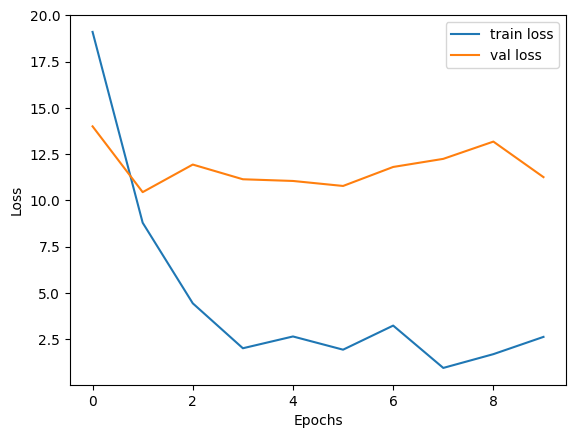

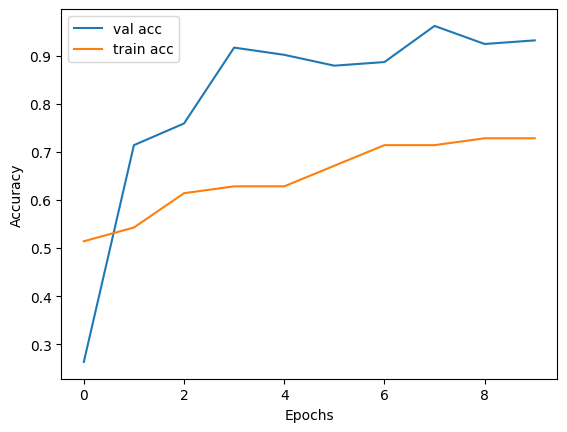

In [13]:
#plot the loss
plt.plot(history_mobilenet_final.history['loss'], label='train loss')
plt.plot(history_mobilenet_final.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# plot the accuracy
plt.plot(history_mobilenet_final.history['accuracy'], label='val acc')
plt.plot(history_mobilenet_final.history['val_accuracy'], label='train acc')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [14]:
# dirname = os.path.join(os.path.dirname(__file__))
model_mobilenet_new_final = load_model('mobilenet_final_model.h5')
print("model loaded.")

model loaded.


In [15]:
model_mobilenet_new_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [16]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_data_generator = test_generator.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)


Found 70 images belonging to 20 classes.


In [17]:
predictions = model_mobilenet_new_final.predict(test_data_generator, steps=test_steps_per_epoch)


3/3 [==============================] - 12s 2s/step


In [18]:
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

print(test_data_generator.classes)
print(predicted_classes)

[ 0  0  0  0  1  1  1  2  2  2  2  2  3  3  3  4  4  5  5  5  6  6  6  6
  7  7  8  8  8  9  9 10 10 10 11 11 11 11 11 11 11 12 12 13 13 14 14 14
 15 15 15 15 15 15 15 16 16 16 16 16 16 17 17 18 19 19 19 19 19 19]
[ 9  9  0  0  1  1  1  2  2  2 11 19 12  7  3 16  8 19 19 19  6  6  6  6
 19  7 15  8 19  9  9 10 10 19 11 12 12 11 11 11 11 12 12 13 13 14 14 14
 15 15 15 15 15 15 15 16 16 16 16 16 16 10 10 18 19 19 19 19 19 19]


In [19]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

In [20]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
cmat = confusion_matrix(true_classes, predicted_classes)
acc = accuracy_score(true_classes, predicted_classes)
print(report)
print(cmat)
print(acc)

                        precision    recall  f1-score   support

         Big raho Fish       1.00      0.50      0.67         4
      Black Water Rahu       1.00      1.00      1.00         3
              Cat fish       1.00      0.60      0.75         5
            Dhari Fish       1.00      0.33      0.50         3
           Dilwar fish       0.00      0.00      0.00         2
            Heera Fish       0.00      0.00      0.00         3
    Jalabi Paplat Fish       1.00      1.00      1.00         4
              Moi Fish       0.50      0.50      0.50         2
           Naiser Fish       0.50      0.33      0.40         3
           Paplet Fish       0.50      1.00      0.67         2
           Parrot Fish       0.50      0.67      0.57         3
             Rahu Fish       0.83      0.71      0.77         7
      Red snapper Fish       0.40      1.00      0.57         2
Ringi  like a cat fish       1.00      1.00      1.00         2
             Safi Fish       1.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# importing os module
import os

# Get the list of all files and directories
path = "/content/drive/MyDrive/Halal Fishes Dataset/JPG Halal Fish Splitted dataset/train"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

# print the list
print(dir_list)


Files and directories in ' /content/drive/MyDrive/Halal Fishes Dataset/JPG Halal Fish Splitted dataset/train ' :
['Tacan Fish', 'Zandia or Dhandia Fish', 'Sarum fish', 'Safi Fish', 'remaining', 'Silver carp Fish', 'Ringi  like a cat fish', 'Red snapper Fish', 'Rahu Fish', 'Heera Fish', 'Paplet Fish', 'Dhari Fish', 'Naiser Fish', 'Dilwar fish', 'Cat fish', 'Jalabi Paplat Fish', 'Black Water Rahu', 'Moi Fish', 'Parrot Fish', 'Big raho Fish']


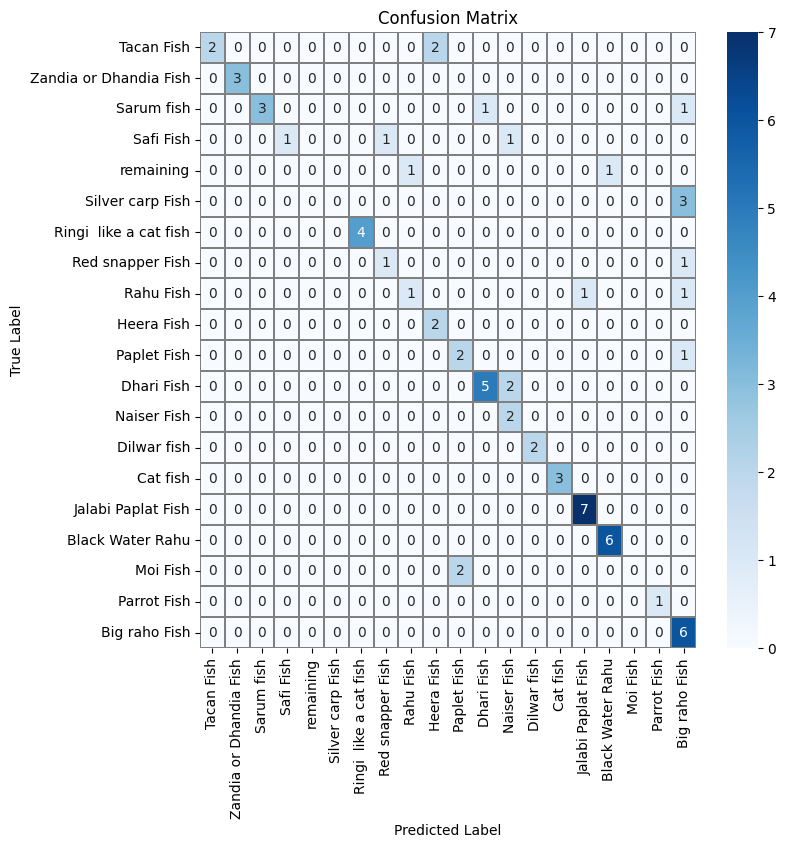

In [23]:
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt='d', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(['Tacan Fish', 'Zandia or Dhandia Fish', 'Sarum fish', 'Safi Fish', 'remaining', 'Silver carp Fish', 'Ringi  like a cat fish', 'Red snapper Fish', 'Rahu Fish', 'Heera Fish', 'Paplet Fish', 'Dhari Fish', 'Naiser Fish', 'Dilwar fish', 'Cat fish', 'Jalabi Paplat Fish', 'Black Water Rahu', 'Moi Fish', 'Parrot Fish', 'Big raho Fish'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.set_yticklabels(['Tacan Fish', 'Zandia or Dhandia Fish', 'Sarum fish', 'Safi Fish', 'remaining', 'Silver carp Fish', 'Ringi  like a cat fish', 'Red snapper Fish', 'Rahu Fish', 'Heera Fish', 'Paplet Fish', 'Dhari Fish', 'Naiser Fish', 'Dilwar fish', 'Cat fish', 'Jalabi Paplat Fish', 'Black Water Rahu', 'Moi Fish', 'Parrot Fish', 'Big raho Fish'])

plt.title("Confusion Matrix")
plt.show()

In [24]:
def get_tpr_fnr_fpr_tnr(cm):
    """
    This function returns class-wise TPR, FNR, FPR & TNR
    [[cm]]: a 2-D array of a multiclass confusion matrix
            where horizontal axes represent actual classes
            and vertical axes represent predicted classes
    {output}: a dictionary of class-wise accuracy parameters
    """
    dict_metric = dict()
    n = len(cm[0])
    row_sums = cm.sum(axis=1)
    col_sums = cm.sum(axis=0)
    array_sum = sum(sum(cm))
    #initialize a blank nested dictionary
    for i in range(1, n+1):
        keys = str(i)
        dict_metric[keys] = {"TPR":0, "FNR":0, "FPR":0, "TNR":0}
    # calculate and store class-wise TPR, FNR, FPR, TNR
    for i in range(n):
        for j in range(n):
            if i == j:
                keys = str(i+1)
                tp = cm[i, j]
                fn = row_sums[i] - cm[i, j]
                dict_metric[keys]["TPR"] = tp / (tp + fn)
                dict_metric[keys]["FNR"] = fn / (tp + fn)
                fp = col_sums[i] - cm[i, j]
                tn = array_sum - tp - fn - fp
                dict_metric[keys]["FPR"] = fp / (fp + tn)
                dict_metric[keys]["TNR"] = tn / (fp + tn)
    return dict_metric

In [26]:
import pandas as pd
df = pd.DataFrame(get_tpr_fnr_fpr_tnr(confusion_mtx)).transpose()
classes = ['Tacan Fish', 'Zandia or Dhandia Fish', 'Sarum fish', 'Safi Fish', 'remaining', 'Silver carp Fish', 'Ringi  like a cat fish', 'Red snapper Fish', 'Rahu Fish', 'Heera Fish', 'Paplet Fish', 'Dhari Fish', 'Naiser Fish', 'Dilwar fish', 'Cat fish', 'Jalabi Paplat Fish', 'Black Water Rahu', 'Moi Fish', 'Parrot Fish', 'Big raho Fish']
df['CLASSES'] = classes
df.set_index('CLASSES', inplace=True)
df

,TPR,FNR,FPR,TNR
CLASSES,,,,
Tacan Fish,0.500000,0.500000,0.000000,1.000000
Zandia or Dhandia Fish,1.000000,0.000000,0.000000,1.000000
Sarum fish,0.600000,0.400000,0.000000,1.000000
Safi Fish,0.333333,0.666667,0.000000,1.000000
remaining,0.000000,1.000000,0.000000,1.000000
Silver carp Fish,0.000000,1.000000,0.000000,1.000000
Ringi like a cat fish,1.000000,0.000000,0.000000,1.000000
Red snapper Fish,0.500000,0.500000,0.014706,0.985294
Rahu Fish,0.333333,0.666667,0.014925,0.985075


In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_mobilenet_new_final)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

In [28]:
print("Mobilenet analysis: ")
print("TPR average: ",df["TPR"].mean())
print("FPR average: ",df["FPR"].mean())
print("TNR average: ",df["TNR"].mean())
print("FNR average: ",df["FNR"].mean())

Mobilenet analysis: 
TPR average:  0.6823809523809523
FPR average:  0.014487872263333193
TNR average:  0.9855121277366667
FNR average:  0.3176190476190476
